# Homework: Stanford Sentiment Treebank

In [1]:
__author__ = "Christopher Potts"
__version__ = "CS224u, Stanford, Spring 2020"

I'm tracking all results in [this spreadsheet](https://docs.google.com/spreadsheets/d/1Bc3s89Vxk5ZnKHeK2BEimoePegCc0B-Mc9tARtrQkVo/edit#gid=0).

## Contents

1. [Overview](#Overview)
1. [Methodological note](#Methodological-note)
1. [Set-up](#Set-up)
1. [A softmax baseline](#A-softmax-baseline)
1. [RNNClassifier wrapper](#RNNClassifier-wrapper)
1. [Error analysis](#Error-analysis)
1. [Homework questions](#Homework-questions)
  1. [Reproducing Socher et al.'s NaiveBayes baselines [2 points]](#Reproducing-Socher-et-al.'s-NaiveBayes-baselines-[2-points])
  1. [Sentiment words alone [2 points]](#Sentiment-words-alone-[2-points])
  1. [A more powerful vector-summing baseline [2 points]](#A-more-powerful-vector-summing-baseline-[2-points])
  1. [Your original system [3 points]](#Your-original-system-[3-points])
1. [Bake-off [1 point]](#Bake-off-[1-point])

## Overview

This homework and associated bake-off are devoted to the Stanford Sentiment Treebank (SST). The homework questions ask you to implement some baseline systems, and the bake-off challenge is to define a system that does extremely well at the SST task.

We'll focus on the ternary task as defined by `sst.ternary_class_func`.

The SST test set will be used for the bake-off evaluation. This dataset is already publicly distributed, so we are counting on people not to cheat by develping their models on the test set. You must do all your development without using the test set at all, and then evaluate exactly once on the test set and turn in the results, with no further system tuning or additional runs. __Much of the scientific integrity of our field depends on people adhering to this honor code__. 

Our only additional restriction is that __you cannot make any use of the subtree labels__. This corresponds to the 'Root' condition in the paper. As we discussed in class, the subtree labels are a really interesting feature of SST, but bringing them in results in a substantially different learning problem.

One of our goals for this homework and bake-off is to encourage you to engage in __the basic development cycle for supervised models__, in which you

1. Write a new feature function. We recommend starting with something simple.
1. Use `sst.experiment` to evaluate your new feature function, with at least `fit_softmax_classifier`.
1. If you have time, compare your feature function with `unigrams_phi` using `sst.compare_models` or `sst.compare_models_mcnemar`. (For discussion, see [this notebook section](sst_02_hand_built_features.ipynb#Statistical-comparison-of-classifier-models).)
1. Return to step 1, or stop the cycle and conduct a more rigorous evaluation with hyperparameter tuning and assessment on the `dev` set.

[Error analysis](#Error-analysis) is one of the most important methods for steadily improving a system, as it facilitates a kind of human-powered hill-climbing on your ultimate objective. Often, it takes a careful human analyst just a few examples to spot a major pattern that can lead to a beneficial change to the feature representations.

## Methodological note

You don't have to use the experimental framework defined below (based on `sst`). However, if you don't use `sst.experiment` as below, then make sure you're training only on `train`, evaluating on `dev`, and that you report with 

```
from sklearn.metrics import classification_report
classification_report(y_dev, predictions)
```
where `y_dev = [y for tree, y in sst.dev_reader(class_func=sst.ternary_class_func)]`. We'll focus on the value at `macro avg` under `f1-score` in these reports.

## Set-up

See [the first notebook in this unit](sst_01_overview.ipynb#Set-up) for set-up instructions.

In [4]:
from collections import Counter
from nltk.tree import Tree
import numpy as np
import os
import pandas as pd
import random
from sklearn.linear_model import LogisticRegression
import sst
from torch import nn, functional as F
from torch_rnn_classifier import TorchRNNClassifier
from torch_tree_nn import TorchTreeNN
import utils
from sklearn.naive_bayes import MultinomialNB

from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
from nltk.corpus import opinion_lexicon
import matplotlib.pyplot as plt

import diskcache
# import spacy
# from spacy.tokens import Doc
import functools
import torch
from functools import lru_cache
from imblearn.over_sampling import RandomOverSampler
from tqdm import tqdm

In [5]:
%matplotlib inline

In [6]:
pd.set_option('max_colwidth', 400)

In [7]:
from IPython.core.display import display, HTML
def display_html(html):
    display(HTML(html))

In [8]:
_spacy_cache = diskcache.Cache(directory='__spacy_cache__')
_nlp = spacy.load('en_core_web_lg')

def process_text(text):
    """Return a spaCy doc for the given text.
    Docs are cached to disk (very inefficiently, but it should work for development.)
    """
    doc_as_bytes = _spacy_cache.get(text)
    
    if doc_as_bytes is None:
        doc = _nlp(text)
        _spacy_cache[text] = doc.to_bytes()
    else:
        doc = Doc(vocab=_nlp.vocab).from_bytes(doc_as_bytes)
    
    return doc

NameError: name 'spacy' is not defined

In [9]:
SST_HOME = os.path.join('data', 'trees')

## A softmax baseline

This example is here mainly as a reminder of how to use our experimental framework with linear models.

In [10]:
def unigrams_phi(tree):
    """The basis for a unigrams feature function.
    
    Parameters
    ----------
    tree : nltk.tree
        The tree to represent.
    
    Returns
    -------    
    Counter
        A map from strings to their counts in `tree`. (Counter maps a 
        list to a dict of counts of the elements in that list.)
    
    """
    return Counter(tree.leaves())

Thin wrapper around `LogisticRegression` for the sake of `sst.experiment`:

In [11]:
# Note that this isn't really softmax since sklearn is using the one-vs-rest strategy,
# training one classifier for each class. We would have to use the 'multinomial' strategy
# to actually do softmax. But trying that took a long time and my fan was getting loud so
# I didn't actually check performance.
def fit_softmax_classifier(X, y, C=1.0):      
    mod = LogisticRegression(
        fit_intercept=True,
        solver='liblinear',
        multi_class='ovr',
        C=C)
    mod.fit(X, y)
    return mod

In [12]:
def fit_softmax_with_crossvalidation(X, y):
    """A MaxEnt model of dataset with hyperparameter 
    cross-validation. Some notes:
        
    * 'fit_intercept': whether to include the class bias feature.
    * 'C': weight for the regularization term (smaller is more regularized).
    * 'penalty': type of regularization -- roughly, 'l1' ecourages small 
      sparse models, and 'l2' encourages the weights to conform to a 
      gaussian prior distribution.
    
    Other arguments can be cross-validated; see 
    http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
    
    Parameters
    ----------
    X : 2d np.array
        The matrix of features, one example per row.
        
    y : list
        The list of labels for rows in `X`.   
    
    Returns
    -------
    sklearn.linear_model.LogisticRegression
        A trained model instance, the best model found.
    
    """    
    basemod = LogisticRegression(
        fit_intercept=True, 
        solver='liblinear', 
        multi_class='auto')
    cv = 5
    param_grid = {'fit_intercept': [True, False], 
                  'C': [0.4, 0.6, 0.8, 1.0, 2.0, 3.0],
                  'penalty': ['l1','l2']}    
    best_mod = utils.fit_classifier_with_crossvalidation(
        X, y, basemod, cv, param_grid)
    return best_mod

The experimental run with some notes:

In [13]:
softmax_experiment = sst.experiment(
    SST_HOME,
    unigrams_phi,                      # Free to write your own!
    fit_softmax_classifier,            # Free to write your own!
    train_reader=sst.train_reader,     # Fixed by the competition.
    assess_reader=sst.dev_reader,      # Fixed until the bake-off.
    class_func=sst.ternary_class_func) # Fixed by the bake-off rules.

              precision    recall  f1-score   support

    negative      0.628     0.689     0.657       428
     neutral      0.343     0.153     0.211       229
    positive      0.629     0.750     0.684       444

    accuracy                          0.602      1101
   macro avg      0.533     0.531     0.518      1101
weighted avg      0.569     0.602     0.575      1101



`softmax_experiment` contains a lot of information that you can use for analysis; see [this section below](#Error-analysis) for starter code.

## RNNClassifier wrapper

This section illustrates how to use `sst.experiment` with RNN and TreeNN models.

To featurize examples for an RNN, we just get the words in order, letting the model take care of mapping them into an embedding space.

In [16]:
def rnn_phi(tree):
    return tree.leaves()    

The model wrapper gets the vocabulary using `sst.get_vocab`. If you want to use pretrained word representations in here, then you can have `fit_rnn_classifier` build that space too; see [this notebook section for details](sst_03_neural_networks.ipynb#Pretrained-embeddings).

In [17]:
def fit_rnn_classifier(X, y):    
    sst_glove_vocab = utils.get_vocab(X, n_words=10000)     
    mod = TorchRNNClassifier(
        sst_glove_vocab, 
        eta=0.05,
        embedding=None,
        batch_size=1000,
        embed_dim=50,
        hidden_dim=50,
        max_iter=50,
        l2_strength=0.001,
        bidirectional=True,
        hidden_activation=nn.ReLU())
    mod.fit(X, y)
    return mod

In [18]:
rnn_experiment = sst.experiment(
    SST_HOME,
    rnn_phi,
    fit_rnn_classifier, 
    vectorize=False,  # For deep learning, use `vectorize=False`.
    assess_reader=sst.dev_reader)

Finished epoch 50 of 50; error is 2.2185898572206497

              precision    recall  f1-score   support

    negative      0.593     0.666     0.627       428
     neutral      0.290     0.205     0.240       229
    positive      0.638     0.658     0.647       444

   micro avg      0.567     0.567     0.567      1101
   macro avg      0.507     0.510     0.505      1101
weighted avg      0.548     0.567     0.555      1101



## Error analysis

This section begins to build an error-analysis framework using the dicts returned by `sst.experiment`. These have the following structure:

```
'model': trained model
'train_dataset':
   'X': feature matrix
   'y': list of labels
   'vectorizer': DictVectorizer,
   'raw_examples': list of raw inputs, before featurizing   
'assess_dataset': same structure as the value of 'train_dataset'
'predictions': predictions on the assessment data
'metric': `score_func.__name__`, where `score_func` is an `sst.experiment` argument
'score': the `score_func` score on the assessment data
```
The following function just finds mistakes, and returns a `pd.DataFrame` for easy subsequent processing:

In [19]:
def find_errors(experiment):
    """Find mistaken predictions.
    
    Parameters
    ----------
    experiment : dict
        As returned by `sst.experiment`.
        
    Returns
    -------
    pd.DataFrame
    
    """
    raw_examples = experiment['assess_dataset']['raw_examples']
    raw_examples = [" ".join(tree.leaves()) for tree in raw_examples]
    df = pd.DataFrame({
        'raw_examples': raw_examples,
        'predicted': experiment['predictions'],
        'gold': experiment['assess_dataset']['y']})
    df['correct'] = df['predicted'] == df['gold']
    return df

In [20]:
softmax_analysis = find_errors(softmax_experiment)

In [22]:
softmax_analysis.head()

,raw_examples,predicted,gold,correct
0,It 's a lovely film with lovely performances b...,positive,positive,True
1,"No one goes unindicted here , which is probabl...",negative,neutral,False
2,And if you 're not nearly moved to tears by a ...,positive,positive,True
3,"A warm , funny , engaging film .",positive,positive,True
4,Uses sharp humor and insight into human nature...,positive,positive,True


In [23]:
rnn_analysis = find_errors(rnn_experiment)

Here we merge the sotmax and RNN experiments into a single DataFrame:

In [24]:
analysis = softmax_analysis.merge(
    rnn_analysis, left_on='raw_examples', right_on='raw_examples')

analysis = analysis.drop('gold_y', axis=1).rename(columns={'gold_x': 'gold'})

The following code collects a specific subset of examples; small modifications to its structure will give you different interesting subsets:

In [25]:
# Examples where the softmax model is correct, the RNN is not,
# and the gold label is 'positive'

error_group = analysis[
    (analysis['predicted_x'] == analysis['gold'])
    &
    (analysis['predicted_y'] != analysis['gold'])    
    &
    (analysis['gold'] == 'positive')
]

In [27]:
for ex in error_group['raw_examples'].sample(5):
    print("="*70)
    print(ex)

An interesting story with a pertinent -LRB- cinematically unique -RRB- message , told fairly well and scored to perfection , I found myself struggling to put my finger on that elusive `` missing thing . ''
Having had the good sense to cast actors who are , generally speaking , adored by the movie-going public , Khouri then gets terrific performances from them all .
But it still jingles in the pocket .
That is a compliment to Kuras and Miller .
-LRB- Næs -RRB- directed the stage version of Elling , and gets fine performances from his two leads who originated the characters on stage .


## Homework questions

Please embed your homework responses in this notebook, and do not delete any cells from the notebook. (You are free to add as many cells as you like as part of your responses.)

### Reproducing Socher et al.'s NaiveBayes baselines [2 points]

[Socher et al.](https://www.aclweb.org/anthology/D13-1170/) compare against (among other models) a NaiveBayes baseline with bigram features. See how close you can come to reproducing the performance of that model on the binary, root-only problem (values in the rightmost column of their Table 1, rows 1 and 3).

Specific tasks:

1. Write a bigrams feature function called `bigrams_phi` on the model of `unigrams_phi`. The included function `test_bigrams_phi` should help verify that you've done this correctly.
1. Write a function `fit_nb_classifier` that serves as a wrapper for `sklearn.naive_bayes.MultinomialNB`, which you can use with all its default arguments or change them as you see fit.
1. Use `sst.experiment` to run the experiments, assessing against `sst.dev_reader`.

Submit all the code you write for this, including any new import statements, and make sure your notebook embeds the output from running the code in step 3.

__A note on performance__: in our experience, the bigrams Naive Bayes model gets around 0.75. It's fine to submit answers with comparable numbers; the Socher et al. baselines are very strong. We're not evaluating how good your model is; we want to see your code, and we're interested to see what the range of F1 scores is across the whole class.

In [105]:
##### YOUR CODE HERE
def test_bigrams_phi(func):
    """`func` should be `bigrams_phi`."""
    tree = Tree.fromstring("""(4 (2 NLU) (4 (2 is) (4 amazing)))""")
    result = bigrams_phi(tree)
    expected = {('<S>', 'NLU'): 1, 
                ('NLU', 'is'): 1, 
                ('is', 'amazing'): 1, 
                ('amazing', '</S>'): 1}
    assert result == expected, \
        "Expected {}\nGot {}".format(expected, result)
def ngrams(tokens, n):
    for i in range(0, len(tokens) - n + 1):
        yield tuple(tokens[i: i+n])

def bigrams_phi(tree):
    tokens = ['<S>'] + tree.leaves() + ['</S>']
    bigrams = ngrams(tokens, 2)
    
    return Counter(bigrams)

test_bigrams_phi(bigrams_phi)


def fit_nb_classifier(X, y):        
    mod = MultinomialNB()
    mod.fit(X, y)
    return mod

nb_experiment = sst.experiment(
    SST_HOME,
    bigrams_phi,
    fit_nb_classifier,
    class_func=sst.binary_class_func,
    assess_reader=sst.dev_reader
)

              precision    recall  f1-score   support

    negative      0.774     0.696     0.733       428
    positive      0.733     0.804     0.767       444

   micro avg      0.751     0.751     0.751       872
   macro avg      0.754     0.750     0.750       872
weighted avg      0.753     0.751     0.750       872



### Sentiment words alone [2 points]

NLTK includes an easy interface to [Minqing Hu and Bing Liu's __Opinion Lexicon__](https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html), which consists of a list of positive words and a list of negative words. How much of the ternary SST story does this lexicon tell?

For this problem, submit code to do the following:

1. Create a feature function `op_unigrams` on the model of `unigrams_phi` above, but filtering the vocabulary to just items that are members of the Opinion Lexicon. Submit this feature function.

1. Evaluate your feature function with `sst.experiment`, with all the same parameters as were used to create `softmax_experiment` in [A softmax baseline](#A-softmax-baseline) above, except of course for the feature function.

1. Use `utils.mcnemar` to compare your feature function with the results in `softmax_experiment`. The information you need for this is in `softmax_experiment` and your own `sst.experiment` results. Submit your evaluation code. You can assume `softmax_experiment` is already in memory, but your code should create the other objects necessary for this comparison.

In [135]:
# Use set for fast membership checking:
positive = set(opinion_lexicon.positive())
negative = set(opinion_lexicon.negative())
sentiment_words = positive | negative

##### YOUR CODE HERE
def op_unigrams(tree):
    return {
        word: freq
        for (word, freq) in unigrams_phi(tree).items()
        if word in sentiment_words
        
    }


opinion_experiment = sst.experiment(
    SST_HOME,
    op_unigrams,                    
    fit_softmax_classifier,
    assess_reader=sst.dev_reader
)

              precision    recall  f1-score   support

    negative      0.553     0.752     0.638       428
     neutral      0.179     0.031     0.052       229
    positive      0.615     0.664     0.639       444

   micro avg      0.567     0.567     0.567      1101
   macro avg      0.449     0.482     0.443      1101
weighted avg      0.500     0.567     0.516      1101



In [136]:
y_true = opinion_experiment['assess_dataset']['y']
assert y_true == softmax_experiment['assess_dataset']['y']

utils.mcnemar(y_true, softmax_experiment['predictions'], opinion_experiment['predictions'])

(5.328413284132841, 0.020980477345314247)

### A more powerful vector-summing baseline [2 points]

In [Distributed representations as features](sst_03_neural_networks.ipynb#Distributed-representations-as-features), we looked at a baseline for the ternary SST problem in which each example is modeled as the sum of its 50-dimensional GloVe representations. A `LogisticRegression` model was used for prediction. A neural network might do better with these representations, since there might be complex relationships between the input feature dimensions that a linear classifier can't learn. 

To address this question, rerun the experiment with `TorchShallowNeuralClassifier` as the classifier. Specs:
* Use `sst.experiment` to conduct the experiment. 
* Using 3-fold cross-validation, exhaustively explore this set of hyperparameter combinations:
  * The hidden dimensionality at 50, 100, and 200.
  * The hidden activation function as `nn.Tanh` or `nn.ReLU`.
* (For all other parameters to `TorchShallowNeuralClassifier`, use the defaults.)

For this problem, submit code to do the following:

1. Your model wrapper function around `TorchShallowNeuralClassifier`. This function should implement the requisite cross-validation; see [this notebook section](sst_02_hand_built_features.ipynb#Hyperparameter-search) for examples.
1. The classification report as printed by `sst.experiment`. (This will print out when you run `sst.experiment`. That print-out suffices.)
2. The optimal hyperparameters chosen in your experiment. (This too will print out when you run `sst.experiment`. The print-out again suffices.)

We're not evaluating the quality of your model. (We've specified the protocols completely, but there will still be variation in the results.) However, the primary goal of this question is to get you thinking more about this strikingly good baseline feature representation scheme for SST, so we're sort of hoping you feel compelled to try out variations on your own.

In [151]:
_DATA_HOME = 'data'
_GLOVE_HOME = os.path.join(_DATA_HOME, 'glove.6B')

glove_lookup = utils.glove2dict(
    os.path.join(_GLOVE_HOME, 'glove.6B.300d.txt'))

In [161]:
def vsm_leaves_phi(tree, lookup, np_func=np.sum):
    """Represent `tree` as a combination of the vector of its words.
    
    Parameters
    ----------
    tree : nltk.Tree   
    lookup : dict
        From words to vectors.
    np_func : function (default: np.sum)
        A numpy matrix operation that can be applied columnwise, 
        like `np.mean`, `np.sum`, or `np.prod`. The requirement is that 
        the function take `axis=0` as one of its arguments (to ensure
        columnwise combination) and that it return a vector of a 
        fixed length, no matter what the size of the tree is.
    
    Returns
    -------
    np.array, dimension `X.shape[1]`
            
    """      
    allvecs = np.array([lookup[w] for w in tree.leaves() if w in lookup])    
    if len(allvecs) == 0:
        dim = len(next(iter(lookup.values())))
        feats = np.zeros(dim)
    else:       
        feats = np_func(allvecs, axis=0)      
    return feats

def glove_leaves_phi(tree, np_func=np.sum):
    return vsm_leaves_phi(tree, glove_lookup, np_func=np_func)

In [171]:
##### YOUR CODE HERE
X_rnn_train, y_rnn_train = sst.build_rnn_dataset(
    SST_HOME, sst.train_reader, class_func=sst.ternary_class_func)

def fit_shallow_nn_classifier(X, y):
    sst_train_vocab = utils.get_vocab(X_rnn_train, n_words=1000)
    rnn = TorchRNNClassifier(sst_train_vocab)
    rnn.fit(X, y)
    return rnn

# sst.experiment(SST_HOME, glove_leaves_phi, fit_shallow_nn_classifier, vectorize=False)

In [188]:
def make_human_eval(reader, sample_size):
    records = []
    for tree, label in reader:
        text = tree.leaves()
        records.append({
            'label': label,
            'text': ' '.join(tree.leaves()),
        })
    return pd.DataFrame.from_records(records).sample(sample_size)

human_eval_raw_df = make_human_eval(sst.train_reader(SST_HOME), 100)
human_eval_raw_df.to_clipboard()

# http://docs.google.com/spreadsheets/d/1FKuy-muIR3f3_rT4EUGTk-_bVUStXEIPXDSrtf-imIM

In [352]:
human_eval_df = pd.read_csv('sentiment_human_eval.tsv', sep='\t', index_col=0)
human_eval_df.columns = ['label_5', 'my_label_5', 'text']

human_eval_df['label_3'] = human_eval_df.label_5.astype(str).apply(sst.ternary_class_func)
human_eval_df['my_label_3'] = human_eval_df.my_label_5.astype(str).apply(sst.ternary_class_func)

human_eval_df['is_correct'] = human_eval_df.label_3 == human_eval_df.my_label_3


print('Total agreement on 5-way: {:.0f}%'.format((human_eval_df.label_5 == human_eval_df.my_label_5).mean() * 100))
print('Total agreement on 3-way: {:.0f}%'.format(human_eval_df.is_correct.mean() * 100))

Total agreement on 5-way: 51%
Total agreement on 3-way: 78%


In [355]:
human_eval_df[~human_eval_df.is_correct]

,label_5,my_label_5,text,label_3,my_label_3,is_correct
884,,,,,,
4457,2,1,"The actresses may have worked up a back story for the women they portray so convincingly , but viewers do n't get enough of that background for the characters to be involving as individuals rather than types .",neutral,negative,False
1091,3,2,"The stars may be college kids , but the subject matter is as adult as you can get : the temptations of the flesh are unleashed by a slightly crazed , overtly determined young woman and a one-night swim turns into an ocean of trouble .",positive,neutral,False
2117,2,1,It depends on how well flatulence gags fit into your holiday concept .,neutral,negative,False
7266,2,1,"Well , it 's not as pathetic as The Animal .",neutral,negative,False
6400,2,1,Apparently writer-director Attal thought he need only cast himself and his movie-star wife sitting around in their drawers to justify a film .,neutral,negative,False
2268,3,2,"Nicole Kidman evolved from star to superstar some time over the past year , which means that Birthday Girl is the kind of quirkily appealing minor movie she might not make for a while .",positive,neutral,False
4181,2,1,"Directors John Musker and Ron Clements , the team behind The Little Mermaid , have produced sparkling retina candy , but they are n't able to muster a lot of emotional resonance in the cold vacuum of space .",neutral,negative,False
1684,2,1,"Even these tales of just seven children seem at times too many , although in reality they are not enough .",neutral,negative,False
7995,2,1,A Sha-Na-Na sketch punctuated with graphic violence .,neutral,negative,False


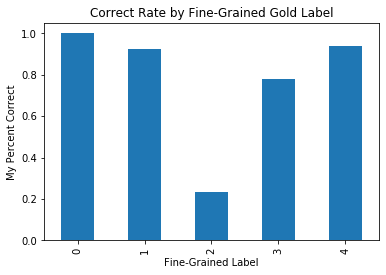

In [372]:
human_eval_df.groupby('label_5').is_correct.mean().plot.bar(title='Correct Rate by Fine-Grained Gold Label')
plt.xlabel('Fine-Grained Label')
_ = plt.ylabel('My Percent Correct')

In [403]:
def show_confusion_matrix_for_my_eval(human_eval_df):
    crosstab = pd.crosstab(human_eval_df.label_3, human_eval_df.my_label_3)
    total = crosstab.sum().sum()

    return crosstab.divide(total).applymap(lambda num: '{}%'.format(int(num * 100)))

display_html("<H4>Confusion Matrix between my judgments and and the gold data<H4>")
show_confusion_matrix_for_my_eval(human_eval_df)

my_label_3,negative,neutral,positive
label_3,,,
negative,36%,2%,0%
neutral,11%,4%,2%
positive,2%,5%,37%


## Conclusions from Human Eval ##
* For the ternary task I only got 78% of the 100 examples correct.
* Only 2% of my errors were from confusing positive and negative.
* The biggest error type at 11% was me thinking gold neutral labels were negative.

In [25]:
def experiment(featurize_func, fit_func, verbose=True, vectorize=True):
    """Wrapper of `sst.experiment` that computes the score against the dev and train sets."""
    score_func = utils.safe_macro_f1
    exp = sst.experiment(
        SST_HOME,
        featurize_func,
        fit_func,
        class_func=sst.ternary_class_func,
        assess_reader=sst.dev_reader,
        score_func=score_func,
        verbose=False,
        vectorize=vectorize
    )
        
    exp['dev_predictions'] = exp['predictions']
    exp['dev_score'] = exp['score']
    del exp['predictions']
    del exp['score']
    
    model = exp['model']
    train_predictions = model.predict(exp['train_dataset']['X'])
    exp['train_predictions'] = train_predictions
    
    exp['train_score'] = score_func(exp['train_dataset']['y'], train_predictions)
    
    if verbose is True:
        display_html("<H2>Train</H2>")
        print(classification_report(exp['train_dataset']['y'], train_predictions, digits=3))
        

        display_html("<H2>Dev</H2>")
        print(classification_report(exp['assess_dataset']['y'], exp['dev_predictions'], digits=3))

    return exp

### Your original system [3 points]

Your task is to develop an original model for the SST ternary problem, using only the root-level labels (again, __you cannot make any use of the subtree labels__). There are many options. If you spend more than a few hours on this homework problem, you should consider letting it grow into your final project! Here are some relatively manageable ideas that you might try:

1. We didn't systematically evaluate the `bidirectional` option to the `TorchRNNClassifier`. Similarly, that model could be tweaked to allow multiple LSTM layers (at present there is only one), and you could try adding layers to the classifier portion of the model as well.

1. We've already glimpsed the power of rich initial word representations, and later in the course we'll see that smart initialization usually leads to a performance gain in NLP, so you could perhaps achieve a winning entry with a simple model that starts in a great place.

1. The [practical introduction to contextual word representations](contextualreps.ipynb) (to be discussed later in the quarter) covers pretrained representations and interfaces that are likely to boost the performance of any system.

1. The `TreeNN` and `TorchTreeNN` don't perform all that well, and this could be for the same reason that RNNs don't peform well: the gradient signal doesn't propagate reliably down inside very deep trees. [Tai et al. 2015](https://aclanthology.info/papers/P15-1150/p15-1150) sought to address this with TreeLSTMs, which are fairly easy to implement in PyTorch.

1. In the [distributed representations as features](#Distributed-representations-as-features) section, we just summed  all of the leaf-node GloVe vectors to obtain a fixed-dimensional representation for all sentences. This ignores all of the tree structure. See if you can do better by paying attention to the binary tree structure: write a function `glove_subtree_phi` that obtains a vector representation for each subtree by combining the vectors of its daughters, with the leaf nodes again given by GloVe (any dimension you like) and the full representation of the sentence given by the final vector obtained by this recursive process. You can decide on how you combine the vectors. 

1. If you have a lot of computing resources, then you can fire off a large hyperparameter search over many parameter values. All the model classes for this course are compatible with the `scikit-learn` and [scikit-optimize](https://scikit-optimize.github.io) methods, because they define the required functions for getting and setting parameters.

We want to emphasize that this needs to be an __original__ system. It doesn't suffice to download code from the Web, retrain, and submit. You can build on others' code, but you have to do something new and meaningful with it.

In the cell below, please provide a brief technical description of your original system, so that the teaching team can gain an understanding of what it does. This will help us to understand your code and analyze all the submissions to identify patterns and strategies.

In [ ]:
# Enter your system description in this cell.
# Please do not remove this comment.



In [259]:
def fit_random_classifier(X, y):
    model = DummyClassifier('uniform')
    model.fit(X, y)
    return model

random_classifier_experiment = experiment(unigrams_phi, fit_random_classifier)

              precision    recall  f1-score   support

    negative      0.386     0.327     0.354      3310
     neutral      0.184     0.323     0.234      1624
    positive      0.412     0.329     0.366      3610

   micro avg      0.327     0.327     0.327      8544
   macro avg      0.327     0.326     0.318      8544
weighted avg      0.359     0.327     0.336      8544



              precision    recall  f1-score   support

    negative      0.371     0.308     0.337       428
     neutral      0.213     0.349     0.265       229
    positive      0.411     0.342     0.373       444

   micro avg      0.331     0.331     0.331      1101
   macro avg      0.332     0.333     0.325      1101
weighted avg      0.354     0.331     0.337      1101



In [264]:
def fit_most_common_class_classifier(X, y):
    model = DummyClassifier('prior')
    model.fit(X, y)
    return model

most_common_class_experiment = experiment(unigrams_phi, fit_most_common_class_classifier)

              precision    recall  f1-score   support

    negative      0.000     0.000     0.000      3310
     neutral      0.000     0.000     0.000      1624
    positive      0.423     1.000     0.594      3610

   micro avg      0.423     0.423     0.423      8544
   macro avg      0.141     0.333     0.198      8544
weighted avg      0.179     0.423     0.251      8544



              precision    recall  f1-score   support

    negative      0.000     0.000     0.000       428
     neutral      0.000     0.000     0.000       229
    positive      0.403     1.000     0.575       444

   micro avg      0.403     0.403     0.403      1101
   macro avg      0.134     0.333     0.192      1101
weighted avg      0.163     0.403     0.232      1101



In [266]:
unigrams_nb_experiment = experiment(unigrams_phi, fit_nb_classifier)

              precision    recall  f1-score   support

    negative      0.820     0.953     0.881      3310
     neutral      0.990     0.481     0.647      1624
    positive      0.870     0.942     0.905      3610

   micro avg      0.858     0.858     0.858      8544
   macro avg      0.893     0.792     0.811      8544
weighted avg      0.873     0.858     0.847      8544



              precision    recall  f1-score   support

    negative      0.635     0.757     0.691       428
     neutral      0.500     0.057     0.102       229
    positive      0.634     0.806     0.710       444

   micro avg      0.631     0.631     0.631      1101
   macro avg      0.590     0.540     0.501      1101
weighted avg      0.606     0.631     0.576      1101



In [270]:
unigrams_softmax_experiment = experiment(unigrams_phi, fit_softmax_classifier)

              precision    recall  f1-score   support

    negative      0.945     0.983     0.964      3310
     neutral      0.981     0.862     0.918      1624
    positive      0.963     0.980     0.971      3610

   micro avg      0.959     0.959     0.959      8544
   macro avg      0.963     0.942     0.951      8544
weighted avg      0.959     0.959     0.958      8544



              precision    recall  f1-score   support

    negative      0.628     0.689     0.657       428
     neutral      0.343     0.153     0.211       229
    positive      0.629     0.750     0.684       444

   micro avg      0.602     0.602     0.602      1101
   macro avg      0.533     0.531     0.518      1101
weighted avg      0.569     0.602     0.575      1101



In [267]:
bigrams_nb_experiment = experiment(bigrams_phi, fit_nb_classifier)

              precision    recall  f1-score   support

    negative      0.979     0.998     0.988      3310
     neutral      0.999     0.936     0.967      1624
    positive      0.986     0.996     0.991      3610

   micro avg      0.985     0.985     0.985      8544
   macro avg      0.988     0.977     0.982      8544
weighted avg      0.986     0.985     0.985      8544



              precision    recall  f1-score   support

    negative      0.600     0.678     0.637       428
     neutral      0.350     0.031     0.056       229
    positive      0.592     0.797     0.679       444

   micro avg      0.591     0.591     0.591      1101
   macro avg      0.514     0.502     0.457      1101
weighted avg      0.545     0.591     0.533      1101



In [271]:
bigrams_softmax_experiment = experiment(bigrams_phi, fit_softmax_classifier)

              precision    recall  f1-score   support

    negative      0.999     1.000     0.999      3310
     neutral      1.000     0.994     0.997      1624
    positive      0.999     1.000     0.999      3610

   micro avg      0.999     0.999     0.999      8544
   macro avg      0.999     0.998     0.999      8544
weighted avg      0.999     0.999     0.999      8544



              precision    recall  f1-score   support

    negative      0.570     0.614     0.592       428
     neutral      0.319     0.066     0.109       229
    positive      0.572     0.764     0.654       444

   micro avg      0.560     0.560     0.560      1101
   macro avg      0.487     0.481     0.451      1101
weighted avg      0.519     0.560     0.516      1101



In [269]:
_sentiment_words = set(opinion_lexicon.positive()) | set(opinion_lexicon.negative())

def opinion_unigrams(tree):
    return {
        word: freq
        for (word, freq) in unigrams_phi(tree).items()
        if word in sentiment_words
        
    }

opinion_unigrams_softmax_experiment = experiment(opinion_unigrams, fit_softmax_classifier)

              precision    recall  f1-score   support

    negative      0.627     0.861     0.726      3310
     neutral      0.881     0.187     0.308      1624
    positive      0.756     0.766     0.761      3610

   micro avg      0.692     0.692     0.692      8544
   macro avg      0.755     0.604     0.598      8544
weighted avg      0.730     0.692     0.661      8544



              precision    recall  f1-score   support

    negative      0.553     0.752     0.638       428
     neutral      0.179     0.031     0.052       229
    positive      0.615     0.664     0.639       444

   micro avg      0.567     0.567     0.567      1101
   macro avg      0.449     0.482     0.443      1101
weighted avg      0.500     0.567     0.516      1101



In [279]:
def opinion_bigrams(tree):
    return {
        bigram: freq
        for (bigram, freq) in bigrams_phi(tree).items()
        if any(word in _sentiment_words for word in bigram)
    
    }
    
    
opinion_bigrams_softmax_experiment = experiment(opinion_bigrams, fit_softmax_classifier)

              precision    recall  f1-score   support

    negative      0.768     0.991     0.865      3310
     neutral      0.999     0.649     0.787      1624
    positive      0.970     0.865     0.915      3610

   micro avg      0.873     0.873     0.873      8544
   macro avg      0.913     0.835     0.856      8544
weighted avg      0.897     0.873     0.871      8544



              precision    recall  f1-score   support

    negative      0.479     0.743     0.582       428
     neutral      0.150     0.013     0.024       229
    positive      0.588     0.552     0.569       444

   micro avg      0.514     0.514     0.514      1101
   macro avg      0.405     0.436     0.392      1101
weighted avg      0.454     0.514     0.461      1101



In [72]:
def text_from_tree(tree):
    sentence = ' '.join(tree.leaves())
    replacements = [
        (" 's", "'s"),
        (' .', '.'),
        (' ,', ','),
        ("`` ", "'"),
        (" ''", "'"),
        (" 'm", "'m"),
        (" 've", "'ve"),
        (" 't", "'t"),
        (" 're", "'re")
    ]
    
    for from_, to in replacements:
        sentence = sentence.replace(from_, to)

    return sentence

def doc_from_tree(tree):
    return process_text(text_from_tree(tree))

In [31]:
# def adjectives(tree):
#     doc = doc_from_tree(tree)
    
#     return Counter(token.lemma_ for token in doc if token.pos_ == 'ADJ')

# adjectives_softmax_experiment = experiment(adjectives, fit_softmax_classifier)

In [ ]:
    tokens = ['<S>'] + tree.leaves() + ['</S>']
    bigrams = ngrams(tokens, 2)

In [333]:
def non_stopword_unigrams(tree):
    doc = doc_from_tree(tree)
    return Counter(
        token.lemma_
        for token in doc
        if not token.is_stop and not token.is_space and not token.is_punct
    )

non_stopwords_softmax_experiment = experiment(non_stopword_unigrams, fit_softmax_classifier)

              precision    recall  f1-score   support

    negative      0.896     0.960     0.927      3310
     neutral      0.979     0.744     0.846      1624
    positive      0.922     0.961     0.941      3610

   micro avg      0.919     0.919     0.919      8544
   macro avg      0.932     0.889     0.905      8544
weighted avg      0.923     0.919     0.918      8544



              precision    recall  f1-score   support

    negative      0.617     0.685     0.649       428
     neutral      0.289     0.105     0.154       229
    positive      0.615     0.752     0.677       444

   micro avg      0.591     0.591     0.591      1101
   macro avg      0.507     0.514     0.493      1101
weighted avg      0.548     0.591     0.557      1101



In [456]:
def non_stopword_bigrams(tree):
    doc = doc_from_tree(tree)
    lemmas = ['<S>'] + [token.lemma_ for token in doc] + ['</S>']
    lemma_bigrams = ngrams(lemmas, 2)
    return Counter(lemma_bigrams)

non_stopword_bigrams_softmax_experiment = experiment(non_stopword_bigrams, fit_softmax_classifier)

              precision    recall  f1-score   support

    negative      0.998     1.000     0.999      3310
     neutral      0.999     0.993     0.996      1624
    positive      0.998     0.999     0.999      3610

   micro avg      0.998     0.998     0.998      8544
   macro avg      0.998     0.997     0.998      8544
weighted avg      0.998     0.998     0.998      8544



              precision    recall  f1-score   support

    negative      0.598     0.621     0.609       428
     neutral      0.328     0.092     0.143       229
    positive      0.590     0.786     0.674       444

   micro avg      0.578     0.578     0.578      1101
   macro avg      0.505     0.500     0.475      1101
weighted avg      0.538     0.578     0.538      1101



In [425]:

from spacy.matcher import Matcher

_matcher = Matcher(_nlp.vocab)
_matcher.add('Phrase', None, [{"POS": "ADJ", "OP": "*"}, {"POS": "NOUN", "OP": "+"}])

def noun_phrases(tree):
    doc = doc_from_tree(tree)
    matches = _matcher(doc)
    seen = set()
    counter = Counter()
    
    spans = [doc[start:end] for (_, start, end) in matches]
    spans.sort(key=len, reverse=True)
    
    for span in sorted(spans, key=len, reverse=True):
        lemma_text = span.lemma_
        
        if lemma_text not in seen:
            counter[lemma_text] += 1
        
        for token in span:
            seen.add(token.lemma_)

    return counter

noun_phrases_softmax_experiment = experiment(noun_phrases, fit_softmax_classifier)

              precision    recall  f1-score   support

    negative      0.869     0.876     0.872      3310
     neutral      0.989     0.565     0.719      1624
    positive      0.797     0.945     0.864      3610

   micro avg      0.846     0.846     0.846      8544
   macro avg      0.885     0.795     0.819      8544
weighted avg      0.861     0.846     0.840      8544



              precision    recall  f1-score   support

    negative      0.517     0.472     0.493       428
     neutral      0.107     0.013     0.023       229
    positive      0.466     0.716     0.565       444

   micro avg      0.475     0.475     0.475      1101
   macro avg      0.363     0.400     0.360      1101
weighted avg      0.411     0.475     0.424      1101



In [455]:
non_stopword_bigrams_softmax_experiment_grid = experiment(non_stopword_bigrams, fit_softmax_with_crossvalidation)

/Users/colin/.pyenv/versions/3.7.4/envs/374/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/colin/.pyenv/versions/3.7.4/envs/374/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/colin/.pyenv/versions/3.7.4/envs/374/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/colin/.pyenv/versions/3.7.4/envs/374/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/colin/.pyenv/versions/3.7.4/envs/374/lib/python3.7/site-packa

Best params: {'C': 3.0, 'fit_intercept': False, 'penalty': 'l2'}
Best score: 0.471


              precision    recall  f1-score   support

    negative      0.999     1.000     1.000      3310
     neutral      1.000     0.999     0.999      1624
    positive      1.000     1.000     1.000      3610

   micro avg      1.000     1.000     1.000      8544
   macro avg      1.000     1.000     1.000      8544
weighted avg      1.000     1.000     1.000      8544



              precision    recall  f1-score   support

    negative      0.599     0.607     0.603       428
     neutral      0.262     0.096     0.141       229
    positive      0.581     0.764     0.660       444

   micro avg      0.564     0.564     0.564      1101
   macro avg      0.481     0.489     0.468      1101
weighted avg      0.522     0.564     0.530      1101



In [469]:
glove_summed_softmax_experiment = experiment(glove_leaves_phi, fit_softmax_classifier, vectorize=False)

              precision    recall  f1-score   support

    negative      0.647     0.778     0.707      3310
     neutral      0.481     0.088     0.149      1624
    positive      0.687     0.812     0.745      3610

   micro avg      0.662     0.662     0.662      8544
   macro avg      0.605     0.560     0.533      8544
weighted avg      0.633     0.662     0.617      8544



              precision    recall  f1-score   support

    negative      0.617     0.722     0.665       428
     neutral      0.286     0.052     0.089       229
    positive      0.622     0.782     0.693       444

   micro avg      0.607     0.607     0.607      1101
   macro avg      0.508     0.519     0.482      1101
weighted avg      0.550     0.607     0.556      1101



In [471]:
glove_averaged_softmax_experiment = experiment(
    lambda tree: glove_leaves_phi(tree, np_func=np.mean),
    fit_softmax_classifier,
    vectorize=False
)

              precision    recall  f1-score   support

    negative      0.640     0.784     0.705      3310
     neutral      0.537     0.076     0.133      1624
    positive      0.686     0.810     0.743      3610

   micro avg      0.661     0.661     0.661      8544
   macro avg      0.621     0.557     0.527      8544
weighted avg      0.640     0.661     0.612      8544



              precision    recall  f1-score   support

    negative      0.613     0.724     0.664       428
     neutral      0.400     0.044     0.079       229
    positive      0.619     0.795     0.696       444

   micro avg      0.611     0.611     0.611      1101
   macro avg      0.544     0.521     0.480      1101
weighted avg      0.571     0.611     0.555      1101



In [620]:
def _glove_averaged_constituents_phi(tree_or_leaf):
    if isinstance(tree_or_leaf, str):
        word = tree_or_leaf
        vector = glove_lookup.get(word)
        return vector

    tree = tree_or_leaf
    
    vectors = []
    for child in tree:
        vector = _glove_averaged_constituents_phi(child)
        if vector is not None:
            vectors.append(vector)
    
    if len(vectors) == 0:
        return None
    else:
        return np.mean(vectors, axis=0)


def glove_averaged_constituents_phi(tree):
    vector = _glove_averaged_constituents_phi(tree)    
    ret = vector if vector is not None else np.zeros(glove_lookup['word'].shape)
    assert isinstance(ret, np.ndarray)
    return ret


glove_constituents_averaged_softmax_experiment = experiment(
    glove_averaged_constituents_phi,
    fit_softmax_classifier,
    vectorize=False
)

              precision    recall  f1-score   support

    negative      0.593     0.673     0.631      3310
     neutral      0.611     0.047     0.088      1624
    positive      0.606     0.783     0.683      3610

   micro avg      0.601     0.601     0.601      8544
   macro avg      0.603     0.501     0.467      8544
weighted avg      0.602     0.601     0.550      8544



              precision    recall  f1-score   support

    negative      0.587     0.654     0.619       428
     neutral      0.556     0.044     0.081       229
    positive      0.569     0.777     0.657       444

   micro avg      0.577     0.577     0.577      1101
   macro avg      0.571     0.492     0.452      1101
weighted avg      0.573     0.577     0.522      1101



In [646]:
def unigrams_negated_phi(tree):
    """The basis for a unigrams feature function.
    
    Parameters
    ----------
    tree : nltk.tree
        The tree to represent.
    
    Returns
    -------    
    Counter
        A map from strings to their counts in `tree`. (Counter maps a 
        list to a dict of counts of the elements in that list.)
    
    """
    token_counts = Counter()
    
    is_negated = False
    for token in tree.leaves():
        if token in ('not', "n't"):
            is_negated = True
        
        elif token in (',;.'):
            is_negated = False
        else:
            new_token = 'not_' + token if is_negated else token
            token_counts[new_token] += 1
            
    return token_counts

unigrams_negated_phi_softmax_experiment = experiment(unigrams_negated_phi, fit_softmax_classifier)

              precision    recall  f1-score   support

    negative      0.953     0.987     0.970      3310
     neutral      0.985     0.873     0.926      1624
    positive      0.968     0.986     0.977      3610

   micro avg      0.965     0.965     0.965      8544
   macro avg      0.969     0.949     0.957      8544
weighted avg      0.965     0.965     0.964      8544



              precision    recall  f1-score   support

    negative      0.629     0.699     0.662       428
     neutral      0.326     0.135     0.191       229
    positive      0.633     0.757     0.689       444

   micro avg      0.605     0.605     0.605      1101
   macro avg      0.530     0.530     0.514      1101
weighted avg      0.568     0.605     0.575      1101



In [832]:
def _get_neutrality_split_data(X, y):
    """Segment X and y into (neutral vs non-neutral) and (pos vs neg)."""
    neutral_indices = [i for (i, y_) in enumerate(y) if y_ == 'neutral']
    negative_indices = [i for (i, y_) in enumerate(y) if y_ == 'negative']
    positive_indices = [i for (i, y_) in enumerate(y) if y_ == 'positive']

    num_neutral = len(neutral_indices)    
    neg_sample = random.sample(negative_indices, num_neutral // 2)
    pos_sample = random.sample(positive_indices, num_neutral // 2)
    
    non_neutral_indices = neg_sample + pos_sample
    
    neutral_X = X[neutral_indices, :]
    neutral_y = [y[i] for i in neutral_indices]

    non_neutral_X = X[non_neutral_indices, :]
    non_neutral_y = ['non_neutral' for i in non_neutral_indices]

    pos_X = X[positive_indices, :]
    pos_y = [y[i] for i in positive_indices]
    
    neg_X = X[negative_indices, :]
    neg_y = [y[i] for i in negative_indices]
    
    neutrality_X = np.concatenate((neutral_X, non_neutral_X))
    neutrality_y = neutral_y + non_neutral_y

    posneg_X = np.concatenate((pos_X, neg_X))
    posneg_y = pos_y + neg_y

    return neutrality_X, neutrality_y, posneg_X, posneg_y
    
    
class TwoPartClassifier:        
    def fit(self, X, y):
        neutrality_X, neutrality_y, posneg_X, posneg_y = _get_neutrality_split_data(X, y)
        self._neutral_model = fit_softmax_classifier(neutrality_X, neutrality_y)
        self._posneg_model = fit_softmax_classifier(posneg_X, posneg_y)
        
    def predict(self, X):
        neutral_classifications = self._neutral_model.predict(X)
        
        unique_neutral_classifications = set(neutral_classifications)

        # This loops through all of the neutrality classifications. Neutrals
        # are put in `y` while non-neutrals are classified by the posneg
        # classifier and that result is put in `y`. Note that this could be
        # optimized by classifying all of `X` that is non-neutral at once.
        y = []        
        for i, classification in enumerate(self._neutral_model.predict(X)):
            if classification == 'neutral':
                y.append(classification)
            else:
                posneg_classification = self._posneg_model.predict(X[i, :].reshape(1, -1)).item()
                assert posneg_classification in ('positive', 'negative')
                y.append(posneg_classification)
        return y

def fit_two_part_softmax(X, y):
    model = TwoPartClassifier()
    model.fit(X, y)
    return model

unigrams_two_part_softmax_experiment = experiment(bigrams_phi, fit_two_part_softmax)

              precision    recall  f1-score   support

    negative      0.999     0.605     0.754      3310
     neutral      0.394     1.000     0.565      1624
    positive      1.000     0.668     0.801      3610

   micro avg      0.707     0.707     0.707      8544
   macro avg      0.797     0.758     0.707      8544
weighted avg      0.884     0.707     0.738      8544



              precision    recall  f1-score   support

    negative      0.580     0.304     0.399       428
     neutral      0.237     0.555     0.332       229
    positive      0.599     0.462     0.522       444

   micro avg      0.420     0.420     0.420      1101
   macro avg      0.472     0.440     0.418      1101
weighted avg      0.517     0.420     0.435      1101



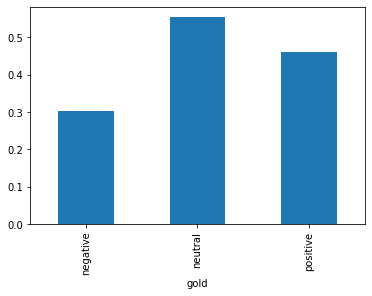

In [838]:
t = unigrams_two_part_softmax_experiment.copy()
t['predictions'] = t['dev_predictions']
a = find_errors(t)
a.groupby('gold').correct.mean().plot.bar()

The two-part classifier greatly improved the performance on neutral gold sentences at the expense of other sentences.

In [17]:
roberta = torch.hub.load('pytorch/fairseq', 'roberta.large')

Using cache found in /home/ubuntu/.cache/torch/hub/pytorch_fairseq_master
100%|██████████| 655283069/655283069 [00:10<00:00, 61535629.42B/s]


loading archive file http://dl.fbaipublicfiles.com/fairseq/models/roberta.large.tar.gz from cache at /home/ubuntu/.cache/torch/pytorch_fairseq/83e3a689e28e5e4696ecb0bbb05a77355444a5c8a3437e0f736d8a564e80035e.c687083d14776c1979f3f71654febb42f2bb3d9a94ff7ebdfe1ac6748dba89d2
extracting archive file /home/ubuntu/.cache/torch/pytorch_fairseq/83e3a689e28e5e4696ecb0bbb05a77355444a5c8a3437e0f736d8a564e80035e.c687083d14776c1979f3f71654febb42f2bb3d9a94ff7ebdfe1ac6748dba89d2 to temp dir /tmp/tmplfv0wre6
| dictionary: 50264 types


1042301B [00:00, 3436989.77B/s]
456318B [00:00, 4857077.92B/s]


In [64]:
%%time

def bert_features(tree):
    text = text_from_tree(tree)
    tokens = roberta.encode(text)
    features = roberta.extract_features(tokens)
    
    return features.cpu().detach().numpy().squeeze().mean(axis=0)

bert_softmax_experiment = experiment(bert_features, fit_softmax_classifier, vectorize=False)

              precision    recall  f1-score   support

    negative      0.763     0.883     0.819      3310
     neutral      0.668     0.284     0.398      1624
    positive      0.809     0.902     0.853      3610

    accuracy                          0.777      8544
   macro avg      0.747     0.690     0.690      8544
weighted avg      0.764     0.777     0.753      8544



              precision    recall  f1-score   support

    negative      0.685     0.827     0.749       428
     neutral      0.397     0.135     0.202       229
    positive      0.745     0.849     0.794       444

    accuracy                          0.692      1101
   macro avg      0.609     0.604     0.582      1101
weighted avg      0.649     0.692     0.653      1101

CPU times: user 7min 28s, sys: 33.2 s, total: 8min 1s
Wall time: 8min 1s


8 minutes on p2.xlarge (down from 36 on my laptop)

In [899]:
%%time

def bert_features(tree):
    text = text_from_tree(tree)
    tokens = roberta.encode(text)
    features = roberta.extract_features(tokens)
    
    return features.detach().numpy().squeeze().mean(axis=0)

bert_softmax_experiment = experiment(bert_features, fit_softmax_classifier, vectorize=False)

              precision    recall  f1-score   support

    negative      0.762     0.892     0.822      3310
     neutral      0.684     0.281     0.399      1624
    positive      0.812     0.899     0.853      3610

   micro avg      0.779     0.779     0.779      8544
   macro avg      0.753     0.691     0.691      8544
weighted avg      0.768     0.779     0.755      8544



              precision    recall  f1-score   support

    negative      0.710     0.808     0.756       428
     neutral      0.422     0.166     0.238       229
    positive      0.729     0.860     0.789       444

   micro avg      0.696     0.696     0.696      1101
   macro avg      0.621     0.612     0.595      1101
weighted avg      0.658     0.696     0.662      1101

CPU times: user 2h 8min 58s, sys: 11min 59s, total: 2h 20min 57s
Wall time: 35min 35s


In [905]:
%%time

def bert_features_v2(tree):
    text = text_from_tree(tree)
    tokens = roberta.encode(text)
    features = roberta.extract_features(tokens)
    
    return features.detach().numpy().squeeze().mean(axis=1)

bert_softmax_experiment_v2_experiment = experiment(bert_features, fit_softmax_classifier, vectorize=False)

              precision    recall  f1-score   support

    negative      0.763     0.888     0.820      3310
     neutral      0.679     0.286     0.403      1624
    positive      0.806     0.894     0.848      3610

   micro avg      0.776     0.776     0.776      8544
   macro avg      0.749     0.689     0.690      8544
weighted avg      0.765     0.776     0.753      8544



              precision    recall  f1-score   support

    negative      0.716     0.794     0.753       428
     neutral      0.353     0.157     0.218       229
    positive      0.737     0.869     0.798       444

   micro avg      0.692     0.692     0.692      1101
   macro avg      0.602     0.607     0.589      1101
weighted avg      0.649     0.692     0.660      1101

CPU times: user 2h 12min 39s, sys: 13min 6s, total: 2h 25min 45s
Wall time: 37min 5s


In [71]:
tree = bert_softmax_experiment['train_dataset']['raw_examples'][0]

In [886]:
def small_train_reader(sst_home, class_func):
    src_filename = os.path.join(sst_home, 'train.txt')
    class_func = sst.ternary_class_func
    with open(src_filename, encoding='utf8') as f:
        for idx, line in enumerate(f):
            tree = Tree.fromstring(line)
            label = class_func(tree.label())
            # As in the paper, if the root node doesn't fall into any
            # of the classes for this version of the problem, then
            # we drop the example:
            if label:
                for subtree in tree.subtrees():
                    subtree.set_label(class_func(subtree.label()))
                yield (tree, label)
            if idx > 10:
                break

## Bert ##

#### end Bert ####

### Error analysis of the best non-DL model so far ###

In [670]:
t = unigrams_negated_phi_softmax_experiment.copy()
t['predictions'] = t['dev_predictions']
analysis = find_errors(t)
analysis.head()

,raw_examples,predicted,gold,correct
0,It 's a lovely film with lovely performances by Buy and Accorsi .,positive,positive,True
1,"No one goes unindicted here , which is probably for the best .",negative,neutral,False
2,"And if you 're not nearly moved to tears by a couple of scenes , you 've got ice water in your veins .",positive,positive,True
3,"A warm , funny , engaging film .",positive,positive,True
4,"Uses sharp humor and insight into human nature to examine class conflict , adolescent yearning , the roots of friendship and sexual identity .",positive,positive,True


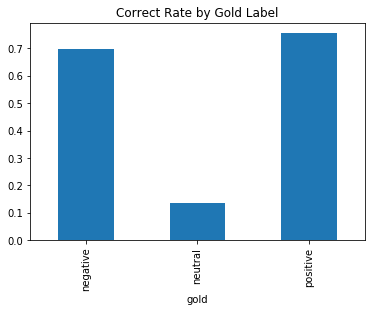

In [671]:
_ = analysis.groupby('gold').correct.mean().plot.bar(title='Correct Rate by Gold Label')

In [726]:
analysis[(analysis.gold != 'neutral') & (analysis.predicted != 'neutral')].correct.mean()

0.7858910891089109

In [706]:
crosstab = pd.crosstab(analysis.gold, analysis.predicted)
total = crosstab.sum().sum()
crosstab / total

predicted,negative,neutral,positive
gold,,,
negative,299,38,91
neutral,94,31,104
positive,82,26,336


In [689]:
analysis[(~analysis.correct) & (analysis.gold=='neutral')].sample(10)

,raw_examples,predicted,gold,correct
322,Writer\/director Mark Romanek spotlights the underlying caste system in America .,positive,neutral,False
401,At all .,negative,neutral,False
354,"Open-minded kids -- kids who read , kids who dream -- will be comforted by the way it deals with big issues like death and destiny .",positive,neutral,False
336,"Although the level of the comedy declines as the movie proceeds , there 's no denying the fun of watching De Niro and Crystal having fun .",positive,neutral,False
236,"Ah yes , and then there 's the music ...",negative,neutral,False
1007,Like the Chelsea 's denizens ... Burdette 's collage-form scenario tends to over-romanticize the spiritual desolation of the struggling artiste .,negative,neutral,False
60,It 's a coming-of-age story we 've all seen bits of in other films -- but it 's rarely been told with such affecting grace and cultural specificity .,positive,neutral,False
578,"Van Wilder does n't bring anything new to the proverbial table , but it does possess a coherence absent in recent crass-a-thons like Tomcats , Freddy Got Fingered , and Slackers .",negative,neutral,False
1038,Not nearly long enough .,negative,neutral,False
558,"Christina Ricci comedy about sympathy , hypocrisy and love is a misfire .",positive,neutral,False


In [687]:
analysis[(~analysis.correct) & (analysis.gold=='negative')].sample(10)

,raw_examples,predicted,gold,correct
1056,It offers little beyond the momentary joys of pretty and weightless intellectual entertainment .,positive,negative,False
677,"The longer the movie goes , the worse it gets , but it 's actually pretty good in the first few minutes .",neutral,negative,False
941,It 's everything you do n't go to the movies for .,neutral,negative,False
1057,A sequence of ridiculous shoot - 'em - up scenes .,neutral,negative,False
600,"The film is based on truth and yet there is something about it that feels incomplete , as if the real story starts just around the corner .",neutral,negative,False
722,"Even on those rare occasions when the narrator stops yammering , Miller 's hand often feels unsure .",positive,negative,False
634,"Expect the same-old , lame-old slasher nonsense , just with different scenery .",positive,negative,False
564,The best that can be said about the work here of Scottish director Ritchie ... is that he obviously does n't have his heart in it .,positive,negative,False
711,"A broad , melodramatic estrogen opera that 's pretty toxic in its own right .",neutral,negative,False
630,"If the movie succeeds in instilling a wary sense of ` there but for the grace of God , ' it is far too self-conscious to draw you deeply into its world .",neutral,negative,False


In [688]:
analysis[(~analysis.correct) & (analysis.gold=='positive')].sample(10)

,raw_examples,predicted,gold,correct
975,"While there 's something intrinsically funny about Sir Anthony Hopkins saying ` Get in the car , bitch , ' this Jerry Bruckheimer production has little else to offer",negative,positive,False
107,What better message than ` love thyself ' could young women of any size receive ?,neutral,positive,False
473,"Whether writer-director Anne Fontaine 's film is a ghost story , an account of a nervous breakdown , a trip down memory lane , all three or none of the above , it is as seductive as it is haunting .",negative,positive,False
434,"On the heels of The Ring comes a similarly morose and humorless horror movie that , although flawed , is to be commended for its straight-ahead approach to creepiness .",negative,positive,False
478,"Another one of those estrogen overdose movies like `` Divine Secrets of the Ya Ya Sisterhood , '' except that the writing , acting and character development are a lot better .",negative,positive,False
346,"Charles ' entertaining film chronicles Seinfeld 's return to stand-up comedy after the wrap of his legendary sitcom , alongside wannabe comic Adams ' attempts to get his shot at the big time .",negative,positive,False
272,"It is amusing , and that 's all it needs to be .",negative,positive,False
284,Overall very good for what it 's trying to do .,neutral,positive,False
68,"Against all odds in heaven and hell , it creeped me out just fine .",negative,positive,False
91,Jaglom ... put -LRB- s -RRB- the audience in the privileged position of eavesdropping on his characters,negative,positive,False


## Bake-off [1 point]

As we said above, the bake-off evaluation data is the official SST test-set release. For this bake-off, you'll evaluate your original system from the above homework problem on the test set, using the ternary class problem. Rules:

1. Only one evaluation is permitted.
1. No additional system tuning is permitted once the bake-off has started.
1. As noted above, __you cannot make any use of the subtree labels__.

The cells below this one constitute your bake-off entry.

Systems that enter will receive the additional homework point, and systems that achieve the top score will receive an additional 0.5 points. We will test the top-performing systems ourselves, and only systems for which we can reproduce the reported results will win the extra 0.5 points.

Late entries will be accepted, but they cannot earn the extra 0.5 points. Similarly, you cannot win the bake-off unless your homework is submitted on time.

The announcement will include the details on where to submit your entry.

In [906]:
# Enter your bake-off assessment code in this cell. 
# Please do not remove this comment.

##### YOUR CODE HERE
%%time

bert_softmax_test = sst.experiment(SST_HOME, bert_features, fit_softmax_classifier, vectorize=False, assess_reader=sst.test_reader)

              precision    recall  f1-score   support

    negative      0.735     0.812     0.772       912
     neutral      0.349     0.152     0.211       389
    positive      0.767     0.871     0.816       909

   micro avg      0.720     0.720     0.720      2210
   macro avg      0.617     0.612     0.600      2210
weighted avg      0.680     0.720     0.691      2210

CPU times: user 2h 6min 5s, sys: 7min 41s, total: 2h 13min 47s
Wall time: 34min 4s


In [907]:
# On an otherwise blank line in this cell, please enter
# your macro-average F1 value as reported by the code above. 
# Please enter only a number between 0 and 1 inclusive.
# Please do not remove this comment.

0.600

0.6

## Re-implementing top Models from the Class ##
* Filter sentences to re-join contractions etc. that were split out. Not sure how much this matters.
* Oversample to balance the dataset. I forgot the neutral set was smaller.

Model
1. [.692] Use HuggingFace Bert to fine-tune the pretrained Bert.
2. [.651] Fine-tune Bert on SST. Run inference to generate features. Use TorchShallowNeuralClassifier

In [910]:
Counter(bert_softmax_experiment['train_dataset']['y'])

Counter({'positive': 3610, 'neutral': 1624, 'negative': 3310})

### TODO ###
* Balance the training set and see how that affects performance.
* Extract bert features for every tree and store them in a dict or something. Write an featurizer that pulls them from the dict. Try it with the logistic regression classifier
* Use the features in a relatively shallow NN. 1024 input features
* Fine-tune bert
  * Read https://mccormickml.com/2019/07/22/BERT-fine-tuning/

In [155]:
def oversampled(fit_func):
    @functools.wraps(fit_func)
    def oversampled_fit_func(X, y):
        oversampler = RandomOverSampler()
        X_new, y_new = oversampler.fit_sample(X, y)
        return fit_func(X_new, y_new)

    return oversampled_fit_func

In [91]:
bert_cache = diskcache.Cache('__bert_cache__')

def _bert_features(text):
    tokens = roberta.encode(text)
    features = roberta.extract_features(tokens)
    
    return features.cpu().detach().numpy().squeeze()

@lru_cache(maxsize=10000)
def bert_features(text):
    from_cache = bert_cache.get(text)
    if from_cache is not None:
        return from_cache
    
    features = _bert_features(text)
    bert_cache[text] = features
    
    return features

In [114]:
def bert_features_mean(tree):
    text = text_from_tree(tree)
    features = bert_features(text)
    return features.mean(0)

In [157]:
bert_softmax_oversampled_exp = experiment(bert_features_mean, oversampled(fit_softmax_classifier), vectorize=False)

              precision    recall  f1-score   support

    negative      0.818     0.799     0.808      3310
     neutral      0.522     0.602     0.559      1624
    positive      0.871     0.829     0.849      3610

    accuracy                          0.774      8544
   macro avg      0.737     0.743     0.739      8544
weighted avg      0.784     0.774     0.778      8544



              precision    recall  f1-score   support

    negative      0.736     0.715     0.725       428
     neutral      0.347     0.367     0.357       229
    positive      0.783     0.782     0.782       444

    accuracy                          0.669      1101
   macro avg      0.622     0.621     0.621      1101
weighted avg      0.674     0.669     0.672      1101



In [ ]:
def fit_nn()

In [287]:
class Net(nn.Module):
    def __init__(self, n_inputs, n_hidden_1, n_hidden_2, n_output_classes):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(n_inputs, n_hidden_1)
        self.fc2 = nn.Linear(n_hidden_1, n_hidden_2)
        self.fc3 = nn.Linear(n_hidden_2, n_output_classes)
        self.g = nn.ReLU()
        self.softmax = nn.Softmax()
    
    def forward(self, x):
        x = self.g(self.fc1(x))
        x = self.g(self.fc2(x))
        x = self.g(self.fc3(x))
        x = self.softmax(x.reshape(-1))
        return x

In [288]:
from torch.utils import data

class MyDataset(data.Dataset):
    def __init__(self, x, y):
        super(MyDataset, self).__init__()
        x = np.array(x)
        y = np.array(y)
        
        assert x.shape[0] == y.shape[0]
        self.x = x
        self.y = y

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

def make_data_loader(X, y, batch_size=32, shuffle=True):
    dataset = MyDataset(X, y)
    return data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    

In [298]:
def train(data_loader, epochs=5):
    assert torch.cuda.is_available()
    device = torch.device('cuda')

    model = Net(1024, 20, 10, 3)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(epochs):
        print(f'Epoch {epoch}')
        for (x_i, y_i) in tqdm(data_loader):
            preds = model(x_i)
            print('preds:', preds.shape)
            print('y_i:', y_i.shape)
            loss = criterion(preds, y_i)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

def fit_nn(X, y):
    y_mapper = {'negative': 0, 'neutral': 1, 'positive': 2}
    y_scalar = np.array([y_mapper[y_] for y_ in y])
    data_loader = make_data_loader(X, y_scalar)    
    return train(data_loader)

In [61]:
tmp = bert_softmax_oversampled_exp['train_dataset']
X = tmp['X']
y = tmp['y']

model = fit_nn(X, y)

NameError: name 'bert_softmax_oversampled_exp' is not defined